# Visualize pose space before and after NN

In [1]:
import cv2
import h5py
import umap
import numpy as np
import pandas as pd
import seaborn as sns
import colorcet as cc
import matplotlib.pyplot as plt
from itertools import repeat
from toolz import valmap
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from aging.size_norm.data import clean
from aging.plotting import format_plots, PlotConfig, save_factory

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/umap/distanc

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "size-normalization", tight_layout=False)

In [3]:
def smooth_clean(frame):
    frame = clean(frame)
    frame = cv2.GaussianBlur(frame, (21, 21), 1.5, 1)
    return frame

In [4]:
paths = [
    '/n/groups/datta/win/longtogeny/data/ontogeny/version_03/all_data_pca/Ontogeny_males/',
    '/n/groups/datta/win/longtogeny/data/ontogeny/version_03/all_data_pca/Ontogeny_females/'
]
paths = [Path(p) for p in paths]

In [5]:
# TODO: exclude sessions ID'd from QC

In [6]:
session_exclusion_list = '/n/groups/datta/win/longtogeny/data/metadata/Ontogeny experiment list - Session quality control.csv'
exclusion_df = pd.read_csv(session_exclusion_list, header=0)
exclusion_df['Keep?'] = exclusion_df['Keep?'].str.lower()
exclusions = exclusion_df.query('`Keep?` != "y"')

In [7]:
exclusions.head()

,File path,Checked?,Keep?,Issue
3,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,y,n,"fading, noise, further inspection needed"
4,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,y,n,noise
5,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,y,n,wall noise
6,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,y,n,replaced with noise
7,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,y,n,wall noise


In [8]:
def get_uuid(path):
    with h5py.File(path, 'r') as h5f:
        return h5f['metadata/uuid'][()].decode()


def check_session(path):
    return get_uuid(path) not in exclusion_uuids


exclusion_uuids = list(map(get_uuid, exclusions['File path'].values))

In [9]:
files = sorted(filter(check_session, paths[0].glob('*.h5')))

In [10]:
def age_map(string) -> int:
    '''returns age in weeks'''
    if '3m' in string:
        return 3 * 4
    if '6m' in string:
        return 6 * 4
    if '12m' in string:
        return 12 * 4
    if '18m' in string:
        return 18 * 4
    if '22m' in string:
        return 22 * 4
    if '3w' in string:
        return 3
    if '5w' in string:
        return 5
    if '7w' in string:
        return 7
    if '9w' in string:
        return 9

In [11]:
sessions_df = []
for f in tqdm(files):
    with h5py.File(f, 'r') as h5f:
        sessions_df.append(dict(
            area=np.median(h5f['scalars/area_px']),
            session=h5f['metadata/acquisition/SessionName'][()].decode(),
            subject=h5f['metadata/acquisition/SubjectName'][()].decode(),
            uuid=h5f['metadata/uuid'][()].decode(),
            file=str(f),
        ))

sessions_df = pd.DataFrame(sessions_df)
sessions_df['age'] = sessions_df['session'].map(age_map)
sessions_df = sessions_df.dropna()
sessions_df = sessions_df[~sessions_df['session'].str.contains('CRL')]

  0%|          | 0/209 [00:00<?, ?it/s]

In [12]:
sessions_df['session'].unique()

array(['3m_ontogeny_cohort_19042021', '3m_ontogeny_cohorts_19042021',
       '3m_ontogey_cohorts_19042021', '6m_ontogeny_cohort_20042021',
       '6m_ontogey_cohorts_20042021', '6m_ontogeny_cohorts_20042021',
       '6m_ontogeny_cohorts_20402021', '6m_ontogeny_cohots_20042021',
       'ontogeny_cohorts_12months_28042021',
       'ontogeny_cohorts_18months_29042021', 'ontogeny_cohorts_3wks',
       'ontogeny_cohorts_5wks', 'ontogeny_cohorts_7wks',
       'ontogeny_cohorts_9wks', 'ontogeny_males_3w', 'ontogney_males_3w',
       'ontogney_males_5w', 'ontogeny_males_5w', 'ontogeny_males_7w',
       'ontogney_males_7w', 'ontogney_males_9w', 'ontogeny_males_9w',
       'ontogeny_males_12months', 'ontogeny_males_18months',
       'ontogeny_males_3months'], dtype=object)

In [13]:
avg_stat = sessions_df.groupby('age').area.mean().sort_values()

In [14]:
inds = dict(map(reversed, enumerate(avg_stat.index)))
inds = valmap(lambda x: x / max(inds.values()), inds)

In [15]:
selected = []
for grp, _df in sessions_df.groupby('age'):
    _idx = int(len(_df) * inds[grp])
    if _idx == len(_df):
        _idx -= 2
    selected.extend(zip(repeat(grp), _df.sort_values(by='area').iloc[_idx:_idx+3]['file']))

In [16]:
selected

[(3.0,
  '/n/groups/datta/win/longtogeny/data/ontogeny/version_03/all_data_pca/Ontogeny_males/session_20230605130947.h5'),
 (3.0,
  '/n/groups/datta/win/longtogeny/data/ontogeny/version_03/all_data_pca/Ontogeny_males/session_20230605131002.h5'),
 (3.0,
  '/n/groups/datta/win/longtogeny/data/ontogeny/version_03/all_data_pca/Ontogeny_males/session_20211029101824.h5'),
 (5.0,
  '/n/groups/datta/win/longtogeny/data/ontogeny/version_03/all_data_pca/Ontogeny_males/session_20230605134846.h5'),
 (5.0,
  '/n/groups/datta/win/longtogeny/data/ontogeny/version_03/all_data_pca/Ontogeny_males/session_20211029123208.h5'),
 (5.0,
  '/n/groups/datta/win/longtogeny/data/ontogeny/version_03/all_data_pca/Ontogeny_males/session_20211029141936.h5'),
 (7.0,
  '/n/groups/datta/win/longtogeny/data/ontogeny/version_03/all_data_pca/Ontogeny_males/session_20211118093950.h5'),
 (7.0,
  '/n/groups/datta/win/longtogeny/data/ontogeny/version_03/all_data_pca/Ontogeny_males/session_20211118115419.h5'),
 (7.0,
  '/n/gro

In [17]:
n_frames = 2500
np.random.seed(0)

all_frames = {}
all_recon_frames = {}
for idx, (age, file) in enumerate(tqdm(selected)):
    with h5py.File(file, 'r') as h5f:
        inds = sorted(np.random.permutation(np.arange(len(h5f['frames'])))[:n_frames])
        all_frames[(idx, age)] = h5f['frames'][inds]
        all_recon_frames[(idx, age)] = h5f['win_size_norm_frames_v2'][inds]

  0%|          | 0/23 [00:00<?, ?it/s]

## Visualize manifold in a few different ways

Label by age

- PCA
- MDS (MDS is taking SO LONG, skipping for now...)
- t-SNE

In [41]:
x = []
y = []
for k, v in all_frames.items():
    y.extend([k[1]] * len(v))
    x.append(list(map(smooth_clean, v)))
x = np.concatenate(x, axis=0)
x = x.reshape(len(x), -1)
y = np.array(y)

In [42]:
pca = PCA(n_components=20)
x_pcs = pca.fit_transform(x)

_range = np.quantile(x_pcs[:, 0],  [0.0005, 0.9995])
mask = (x_pcs[:, 0] > _range[0]) & (x_pcs[:, 0] < _range[1])
_range = np.quantile(x_pcs[:, 1],  [0.0005, 0.9995])
mask &= (x_pcs[:, 1] > _range[0]) & (x_pcs[:, 1] < _range[1])
x_pcs = x_pcs[mask]
y = y[mask]

(0.5, 1.0)

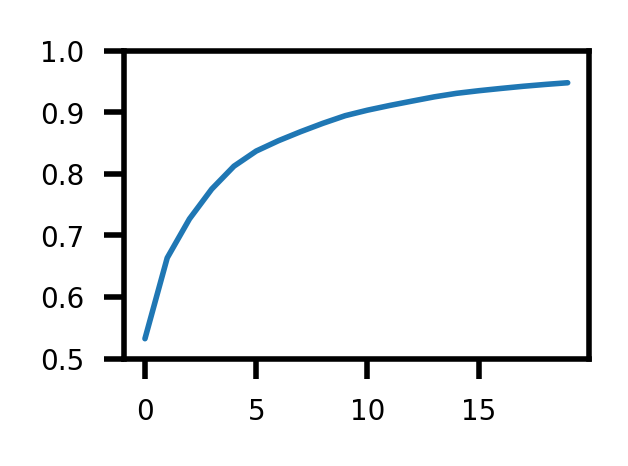

In [43]:
fig = plt.figure(figsize=(1.5, 1))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(0.5, 1)

In [44]:
thinning = 4

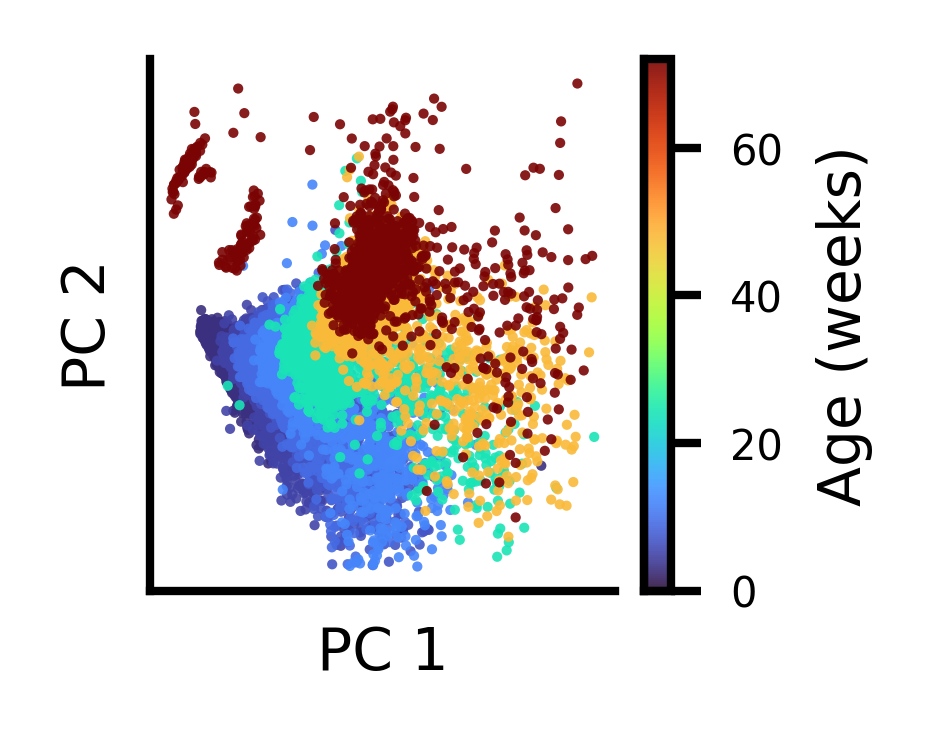

In [45]:
fig = plt.figure(figsize=(1.25, 1.15), dpi=300)
ax = fig.gca()
im = ax.scatter(*x_pcs[::thinning, :2].T, c=y[::thinning], cmap='turbo', s=1.5, lw=0, ec='k', alpha=0.9, vmin=0)
fig.colorbar(im, label='Age (weeks)', ax=ax)
ax.set(xticks=[], yticks=[], xlabel='PC 1', ylabel='PC 2')
sns.despine()
saver(fig, 'pre-model-pcs-across-age');

In [23]:
umap_mdl = umap.UMAP(random_state=0)
latents = umap_mdl.fit_transform(x_pcs)

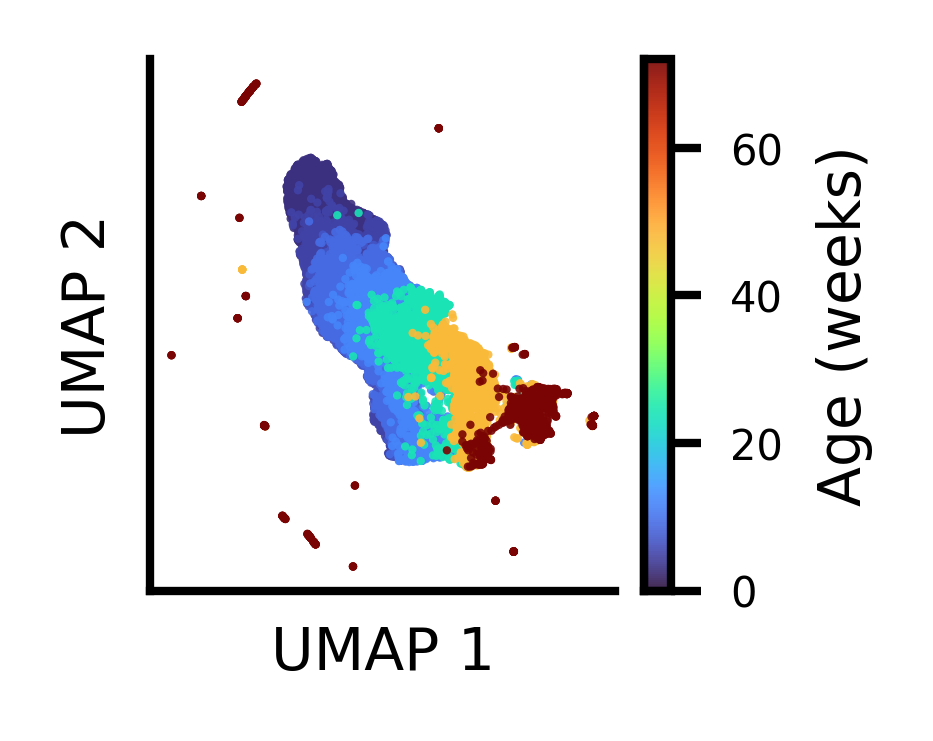

In [24]:
fig = plt.figure(figsize=(1.25, 1.15), dpi=300)
ax = fig.gca()
im = ax.scatter(*latents[::thinning].T, c=y[::thinning], cmap='turbo', s=1, lw=0, ec='k', alpha=0.9, vmin=0)
fig.colorbar(im, label='Age (weeks)', ax=ax)
ax.set(xticks=[], yticks=[], xlabel='UMAP 1', ylabel='UMAP 2')
sns.despine()
saver(fig, 'pre-model-umap-across-age');

In [25]:
x = []
y = []
for k, v in filter(lambda i: i[0][1] in (3.0, 72.0), all_frames.items()):
    y.extend([k[1]] * len(v))
    x.append(list(map(smooth_clean, v)))
x = np.concatenate(x, axis=0)
x = x.reshape(len(x), -1)
y = np.array(y)

In [26]:
x_selection = pca.transform(x)
_range = np.quantile(x_selection[:, 0],  [0.0005, 0.9995])
mask = (x_selection[:, 0] > _range[0]) & (x_selection[:, 0] < _range[1])
x_selection = x_selection[mask]
y = y[mask]

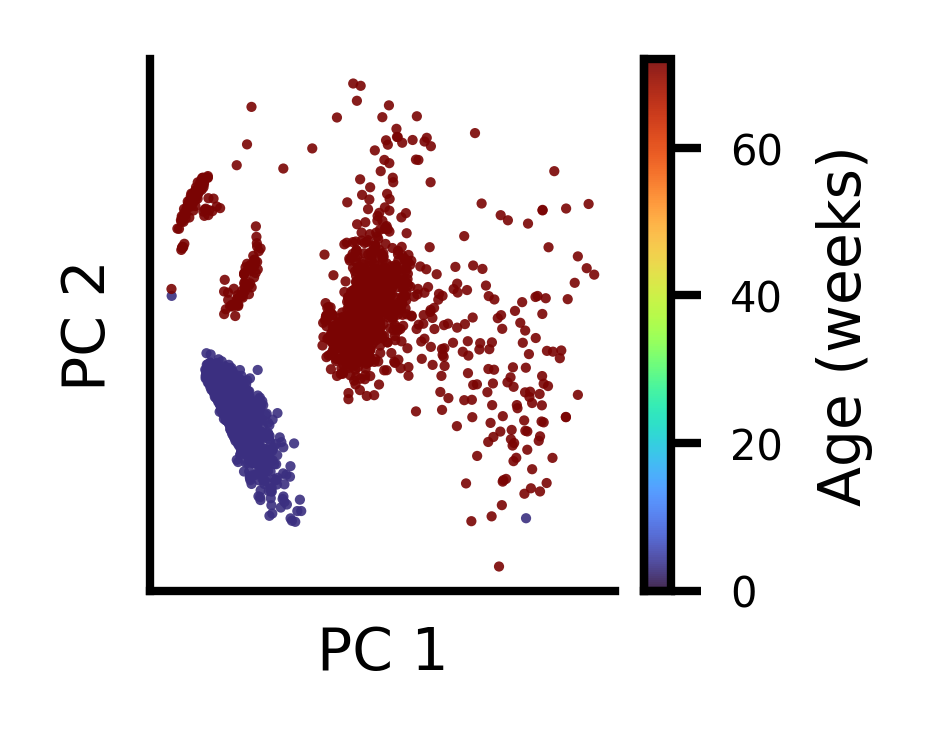

In [28]:
fig = plt.figure(figsize=(1.25, 1.15), dpi=300)
ax = fig.gca()
im = ax.scatter(*x_selection[::thinning, :2].T, c=y[::thinning], cmap='turbo', s=1.5, lw=0, ec='k', alpha=0.9, vmin=0)
fig.colorbar(im, label='Age (weeks)', ax=ax)
ax.set(xticks=[], yticks=[], xlabel='PC 1', ylabel='PC 2')
sns.despine()
saver(fig, 'pre-model-pcs-across-age-yound-old-only');

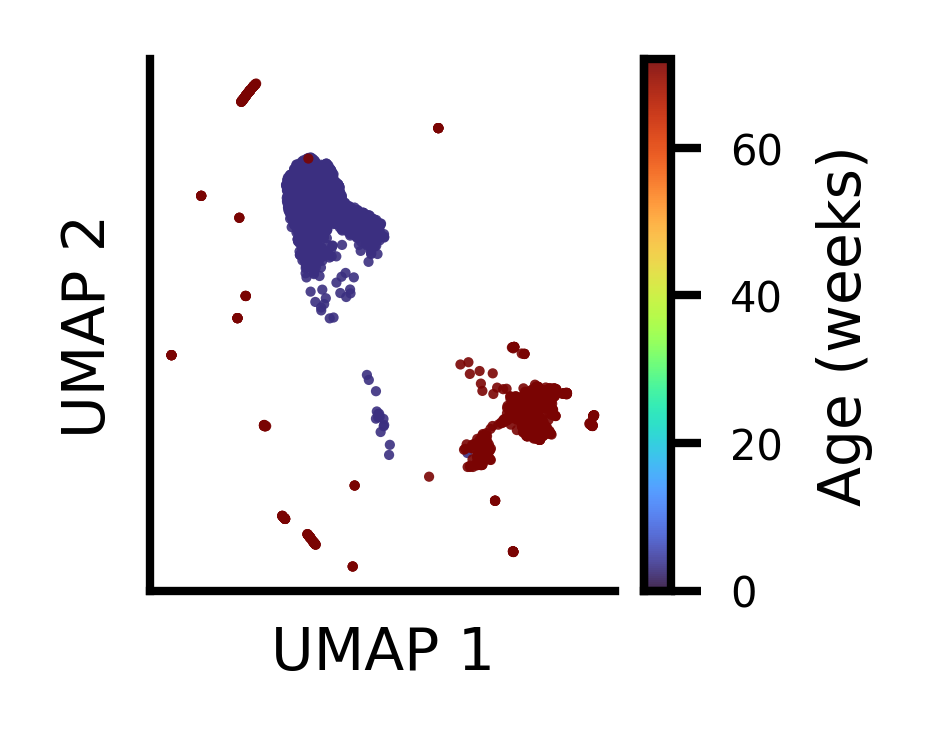

In [30]:
fig = plt.figure(figsize=(1.25, 1.15), dpi=300)
ax = fig.gca()
im = ax.scatter(*umap_mdl.transform(x_selection[::thinning]).T, c=y[::thinning], cmap='turbo', s=1.5, lw=0, ec='k', alpha=0.9, vmin=0)
fig.colorbar(im, label='Age (weeks)', ax=ax)
ax.set(xticks=[], yticks=[], xlabel='UMAP 1', ylabel='UMAP 2')
sns.despine()
saver(fig, 'pre-model-umap-across-age-yound-old-only');

## After NN

In [31]:
x = []
y = []
for k, v in all_recon_frames.items():
    y.extend([k[1]] * len(v))
    # x.append(list(map(clean, v)))
    x.append(v)
x = np.concatenate(x, axis=0)
x = x.reshape(len(x), -1)
y = np.array(y)

In [32]:
pca = PCA(n_components=20)
x_pcs = pca.fit_transform(x)

_range = np.quantile(x_pcs[:, 0],  [0.0005, 0.9995])
mask = (x_pcs[:, 0] > _range[0]) & (x_pcs[:, 0] < _range[1])
_range = np.quantile(x_pcs[:, 1],  [0.0005, 0.9995])
mask &= (x_pcs[:, 1] > _range[0]) & (x_pcs[:, 1] < _range[1])
x_pcs = x_pcs[mask]
y = y[mask]

(0.5, 1.0)

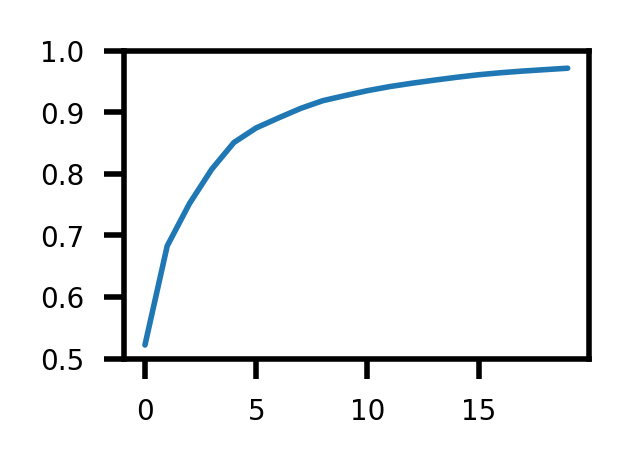

In [33]:
fig = plt.figure(figsize=(1.5, 1))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(0.5, 1)

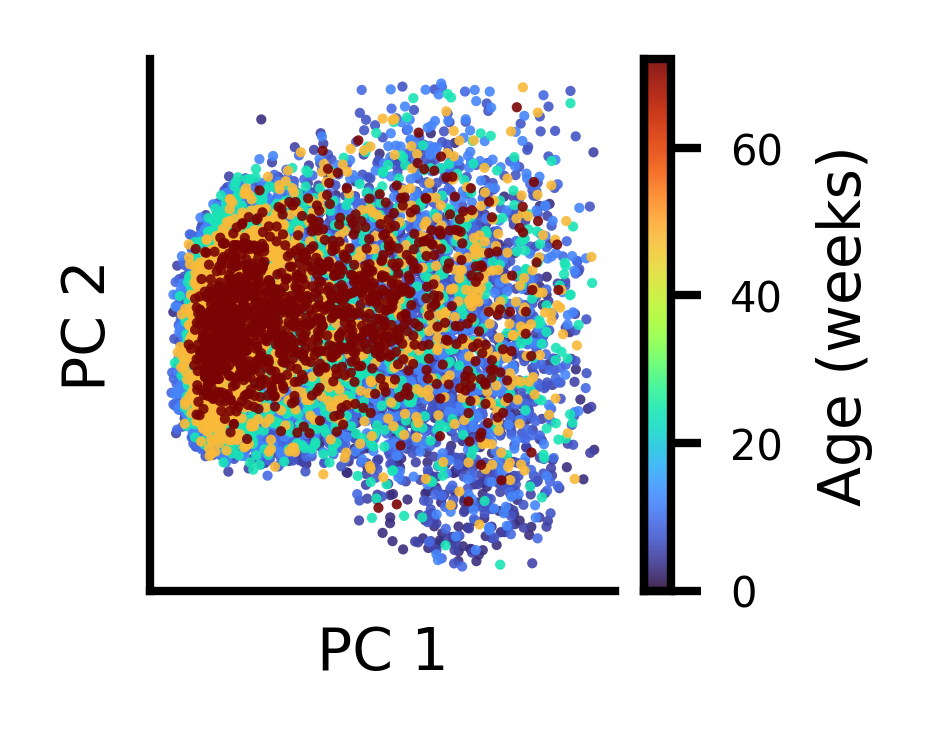

In [34]:
fig = plt.figure(figsize=(1.25, 1.15), dpi=300)
ax = fig.gca()
im = ax.scatter(*x_pcs[::thinning, :2].T, c=y[::thinning], cmap='turbo', s=1.5, lw=0, ec='k', alpha=0.9, vmin=0)
fig.colorbar(im, label='Age (weeks)', ax=ax)
ax.set(xticks=[], yticks=[], xlabel='PC 1', ylabel='PC 2')
sns.despine()
saver(fig, 'post-model-pcs-across-age');

In [35]:
umap_mdl = umap.UMAP(random_state=0)
latents = umap_mdl.fit_transform(x_pcs)

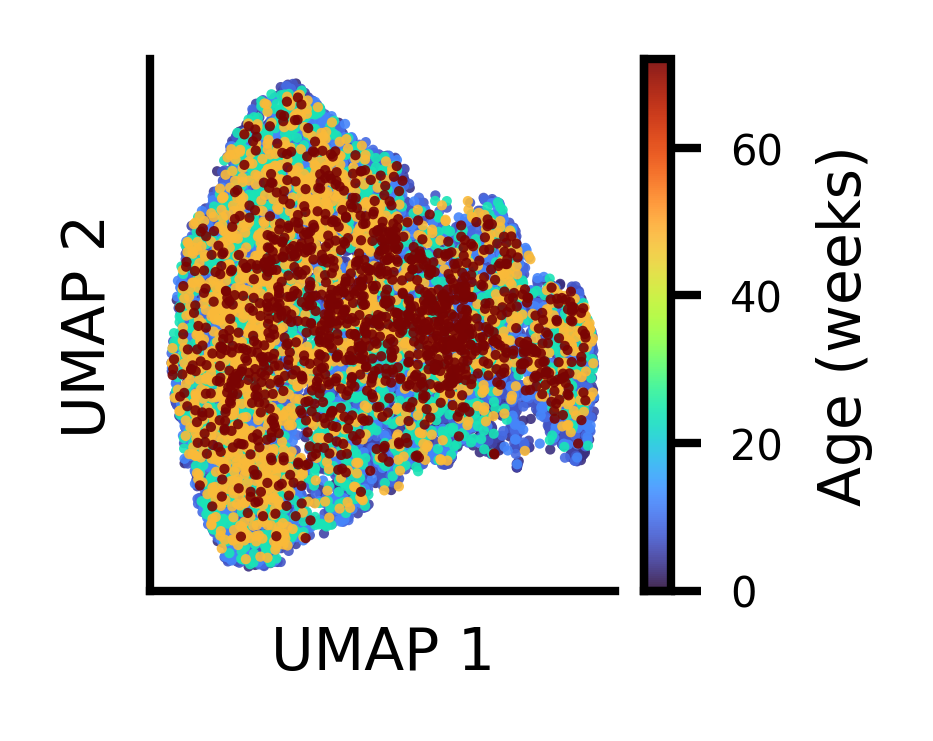

In [36]:
fig = plt.figure(figsize=(1.25, 1.15), dpi=300)
ax = fig.gca()
im = ax.scatter(*latents[::thinning].T, c=y[::thinning], cmap='turbo', s=1.5, lw=0, ec='k', alpha=0.9, vmin=0)
fig.colorbar(im, label='Age (weeks)', ax=ax)
ax.set(xticks=[], yticks=[], xlabel='UMAP 1', ylabel='UMAP 2')
sns.despine()
saver(fig, 'post-model-umap-across-age');

In [37]:
x = []
y = []
for k, v in filter(lambda i: i[0][1] in (3.0, 72.0), all_recon_frames.items()):
    y.extend([k[1]] * len(v))
    x.append(list(map(smooth_clean, v)))
x = np.concatenate(x, axis=0)
x = x.reshape(len(x), -1)
y = np.array(y)

In [38]:
x_selection = pca.transform(x)
_range = np.quantile(x_selection[:, 0],  [0.0005, 0.9995])
mask = (x_selection[:, 0] > _range[0]) & (x_selection[:, 0] < _range[1])
x_selection = x_selection[mask]
y = y[mask]

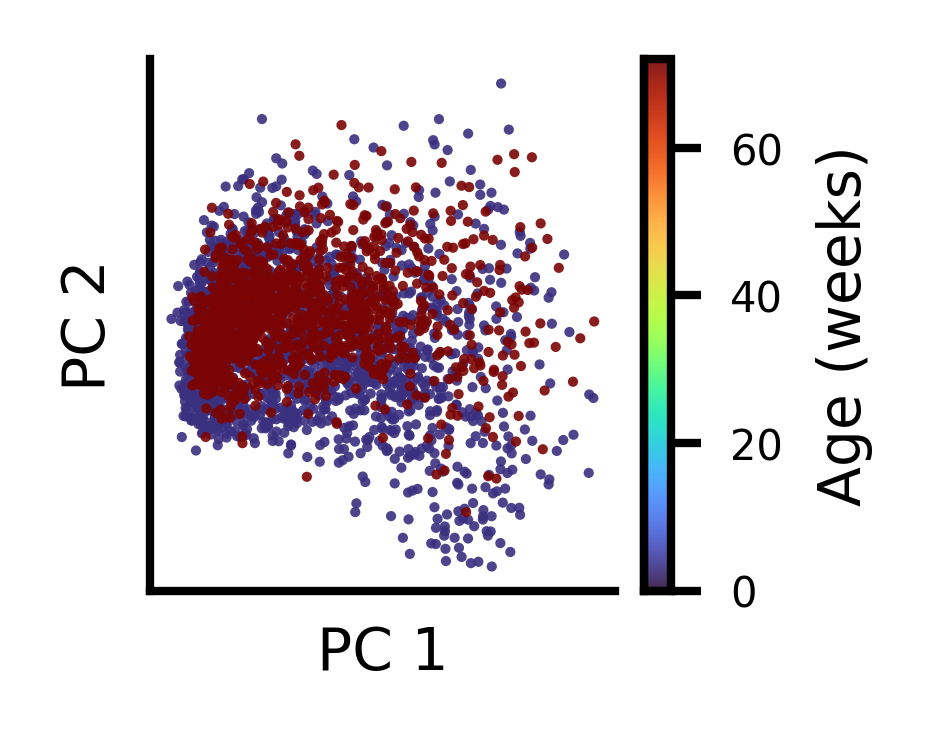

In [39]:
fig = plt.figure(figsize=(1.25, 1.15), dpi=300)
ax = fig.gca()
im = ax.scatter(*x_selection[::thinning, :2].T, c=y[::thinning], cmap='turbo', s=1.5, lw=0, ec='k', alpha=0.9, vmin=0)
fig.colorbar(im, label='Age (weeks)', ax=ax)
ax.set(xticks=[], yticks=[], xlabel='PC 1', ylabel='PC 2')
sns.despine()
saver(fig, 'post-model-pcs-across-age-yound-old-only');

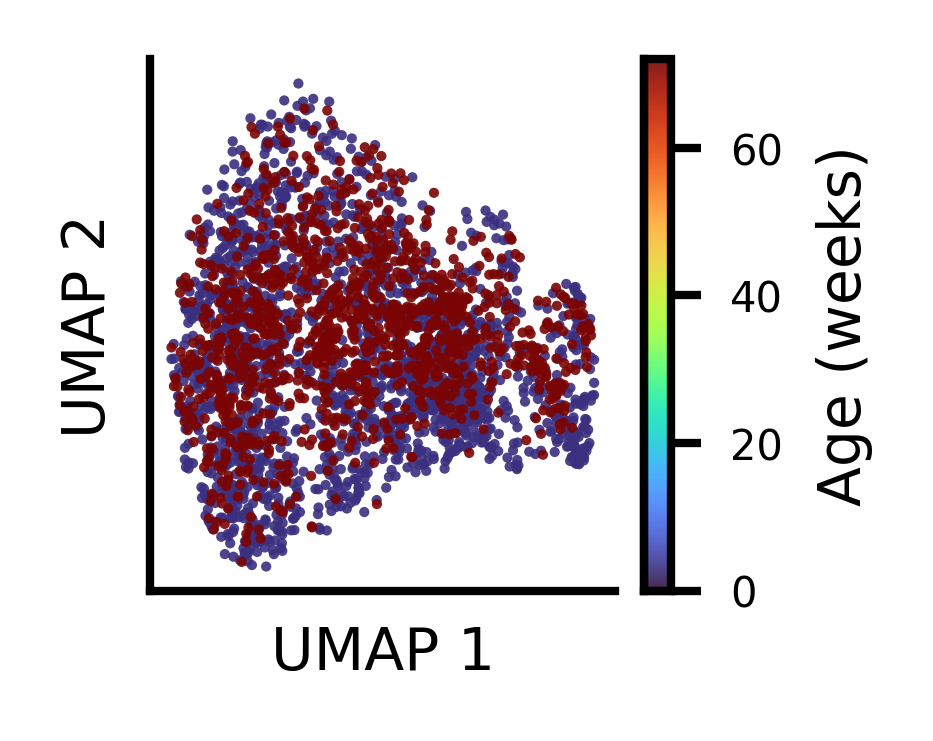

In [40]:
fig = plt.figure(figsize=(1.25, 1.15), dpi=300)
ax = fig.gca()
im = ax.scatter(*umap_mdl.transform(x_selection[::thinning]).T, c=y[::thinning], cmap='turbo', s=1.5, lw=0, ec='k', alpha=0.9, vmin=0)
fig.colorbar(im, label='Age (weeks)', ax=ax)
ax.set(xticks=[], yticks=[], xlabel='UMAP 1', ylabel='UMAP 2')
sns.despine()
saver(fig, 'post-model-umap-across-age-yound-old-only');

## TODO: use holoviews to visualize frames at different points